# Estimize Signal Strategy

In [4]:
# Imports

from datetime import timedelta
from IPython.display import display, HTML, Markdown
import logging.config
import os
import sys

from injector import Injector
import math
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mstats

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from estimize.logging import configure_logging
from estimize.di.default_module import DefaultModule
from estimize.services import (
    AssetService, EstimizeSignalService, MarketCapService
)
from estimize.pandas import dfutils


In [2]:
TIMEZONE = 'US/Eastern'

# Asset universe parameters:
MIN_MARKET_CAP = 100e6
MIN_AVG_DOLLAR_VOL = 1e6
MIN_PRICE = 4

# Signal parameters:
POST_SIGNAL_ONLY = False # If True, only post-earnings signal is used

# Trading parameters:
SIGNAL_QUANTILE = 0.10 # Upper and lower signal quantile to select assets
MIN_ASSETS = 20 # Min number of total long and short assets, below which no trades occur
LEVERAGE_RATIO = 2

configure_logging('INFO')

injector = Injector([DefaultModule])
asset_service = injector.get(AssetService)

def get_assets(tickers):
    asset_service = injector.get(AssetService)
    
    return asset_service.get_assets(tickers)

def get_unique_assets(df):
    return dfutils.unique_assets(df)

def universe(start_date, end_date):
    asset_service = injector.get(AssetService)
    market_cap_service = injector.get(MarketCapService)
    
    cdf = market_cap_service.get_market_caps(start_date, end_date)
    print(len(cdf))
    cdf = cdf.loc[cdf['market_cap'] >= MIN_MARKET_CAP]
    print(len(cdf))
    
    df = asset_service.get_universe(start_date, end_date, min_avg_dollar_vol=MIN_AVG_DOLLAR_VOL, min_price=MIN_PRICE)
    df = df.join(cdf, how='inner')
    df = df[[]]
    
    return df

def day_and_night_returns(start_date, end_date, assets, include_return=False):
    df = asset_service.get_returns(start_date, end_date, assets)[['inter_day_return', 'intra_day_return', 'close_return']]

    df.reset_index(inplace=True)
    df = pd.pivot_table(df, index='as_of_date', columns='asset')
    
    cr = df['close_return'].stack()
    dr = df['intra_day_return'].stack()
    nr = df['inter_day_return'].shift(-1).stack()
    df = pd.DataFrame(dict(dayret=dr, nightret=nr))
    
    if include_return:
        df['return'] = cr
    
    df.reset_index(inplace=True)
    df['as_of_date'] = df['as_of_date'].dt.date
    df.set_index(['as_of_date', 'asset'], inplace=True)
    
    return df

def signals(year):    
    signal_service = injector.get(EstimizeSignalService)
    start_date = '{}-01-01'.format(year)
    end_date = '{}-01-01'.format(year + 1)
    
    df = signal_service.get_signals(start_date, end_date)
    df.dropna(inplace=True)
    
    if POST_SIGNAL_ONLY:
        df = df[df['type'] == 'post']
    
    df.reset_index(inplace=True)
    df['as_of_date'] = df['as_of_date'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
    df['hour'] = df['as_of_date'].dt.hour
    df['as_of_date'] = df['as_of_date'].dt.date
    df.drop(['fiscal_date', 'reports_at_date', 'type', 'bmo'], axis=1, inplace=True)
    df.set_index(['as_of_date', 'asset'], inplace=True)
    
    return df

def longs_and_shorts(signals_df):
    df = signals_df.reset_index()
    gdf = df.groupby(['as_of_date', 'hour'])
    df.set_index(['as_of_date', 'hour'], inplace=True)

    botq = gdf.quantile(SIGNAL_QUANTILE)
    botq.rename(columns={'signal': 'bottom_quantile'}, inplace=True)

    topq = gdf.quantile(1 - SIGNAL_QUANTILE)
    topq.rename(columns={'signal': 'top_quantile'}, inplace=True)

    df = df.join([botq, topq], how='inner')
    df['short'] = df['signal'] <= df['bottom_quantile']
    df['long'] = df['signal'] >= df['top_quantile']
    df = df[df['short'] | df['long']]
    df.drop(['bottom_quantile', 'top_quantile', 'signal'], axis=1, inplace=True)
    
    df['count'] = df.reset_index().groupby(['as_of_date', 'hour'])['asset'].count()
    df = df[df['count'] >= MIN_ASSETS]
    df.drop(['count'], axis=1, inplace=True)
    df.reset_index(inplace=True)
    df.set_index(['as_of_date', 'asset'], inplace=True)
    
    return df

def signal_returns(year):
    start_date = '{}-01-01'.format(year)
    end_date = '{}-01-01'.format(year + 1)
    
    udf = universe(start_date, end_date)
    sdf = signals(year)
    fsdf = sdf.join(udf, how='inner')
    
    lsdf = longs_and_shorts(fsdf)
    assets = dfutils.unique_assets(lsdf)
    
    if len(assets) == 0:
        return pd.DataFrame(columns=['as_of_date', 'return'])
    
    rdf = day_and_night_returns(start_date, end_date, assets)
    
    df = lsdf.join(rdf, how='inner')
    df.loc[df['short'] == True, ['dayret', 'nightret']] *= -1
    df.drop(['long', 'short'], axis=1, inplace=True)
    df.reset_index(inplace=True)
    
    mdf = df[df['hour'] == 7].copy()
    mdf.drop(['nightret'], axis=1, inplace=True)
    mdf.rename(columns={'dayret': 'return'}, inplace=True)
    
    ndf = df[df['hour'] == 14].copy()
    ndf.drop(['dayret'], axis=1, inplace=True)
    ndf.rename(columns={'nightret': 'return'}, inplace=True)
    
    # Calculate morning and overnight returns
    df = pd.concat([mdf, ndf])
    df = df.groupby(['as_of_date', 'hour']).mean()
    
    # Calculate daily returns
    df.reset_index(inplace=True)
    df.drop(['hour'], axis=1, inplace=True)
    df = df.groupby(['as_of_date']).sum()
    
    return df

def show_cumulative_returns(df):
    if not df.empty:
        cdf = ((df + 1).cumprod() - 1) * 100
        cdf.plot()
        plt.xlabel('')
        plt.ylabel('')
        plt.legend(
            ['Cumulative Return'],
            bbox_to_anchor=(0.50, 0.96),
            loc="upper center",
            borderaxespad=0,
            ncol=1
        )
        plt.show()
    
def performance_summary(df):
    if df.empty:
        return None
    
    df.dropna(inplace=True)
    numday = df['return'].count()
    avgret = df['return'].mean()
    stdret = np.std(df['return'])
    
    data = []
    
    if numday > 0 and stdret > 0:
        cumret = ((df['return'] + 1).prod() - 1)
        annret = avgret * 252
        volatl = stdret * math.sqrt(252)
        sharpe = math.sqrt(252) * (avgret / stdret)
        
        data = np.array([df.index[0].year, cumret, avgret, numday, annret, sharpe, volatl]).reshape(1, 7)
        
    columns = [
        'Year',
        'Cumulative Return',
        'Avg Daily Return',
        'Num Trading Days',
        'Return (Annualized)',
        'Sharpe Ratio',
        'Volatility'
    ]
    
    pdf = pd.DataFrame(data=data, columns=columns)
    pdf['Year'] = pdf['Year'].astype(int)
    
    return pdf

def show_yearly_performance(years):
    ardf = None
    aperf = None
    
    for year in years:
        srdf = signal_returns(year)
        srdf['return'] *= LEVERAGE_RATIO

        perf = performance_summary(srdf)
        display(perf)
        
        show_cumulative_returns(srdf)
        
        if ardf is not None:
            ardf = pd.concat([ardf, srdf], copy=False)
            aperf = pd.concat([aperf, perf], copy=False)
        else:
            ardf = srdf
            aperf = perf
            
    show_cumulative_returns(ardf)
    
    aperf.drop(['Year'], axis=1, inplace=True)
    aperf = aperf.mean().to_frame().transpose()
    display(aperf)

    return ardf

def show_yearly_performance_as_table(ardf):
    cdf = ((ardf + 1).cumprod() - 1) * 100

    print(len(cdf))

    group_size = 60
    num_groups = int(math.ceil(float(len(cdf)) / group_size))

    for i in range(0, num_groups):
        start = i * group_size
        end = start + 60

        if end > len(cdf):
            end = -1

        pdf = cdf.iloc[start:end]
        display(pdf)
        
def display_positions(year):
    sdf = signals(year)
    df = longs_and_shorts(sdf)
    
    df.reset_index(inplace=True)
    df['ticker'] = list(map(lambda a: a.symbol, df['asset']))
    df['trade_time'] = 'Market Open'
    df.loc[df['hour'] == 14, 'trade_time'] = 'Market Close'
    df = df[['as_of_date', 'trade_time', 'ticker', 'long', 'short']]
    
    display(df)
    
    return df


In [6]:
# df = display_positions(2017)
# df.to_csv('2017_signal_positions.csv')

# assets = get_assets(['CUDA'])
# df = day_and_night_returns('2016-12-29', '2017-01-9', assets, include_return=True)
# display(df.head())

# df = signals(2017)
# df = df[df.index.get_level_values('asset') == get_assets(['CUDA'])[0]]
# print(len(df))
# display(df.head(10))
# tickers = [a.symbol for a in get_unique_assets(df)]
# tickers.sort()
# display(tickers)

# df = signal_returns(2017)
# display(df.head())

585083
573805
2018-05-02 16:29:49,803 [INFO] estimize.services.impl.estimize_signal_service_default_impl: get_signals: start
2018-05-02 16:29:50,756 [INFO] estimize.services.impl.estimize_signal_service_default_impl: get_signals: end


,Year,Cumulative Return,Avg Daily Return,Num Trading Days,Return (Annualized),Sharpe Ratio,Volatility
0,2012,0.201256,0.001716,110.0,0.432551,2.782389,0.15546


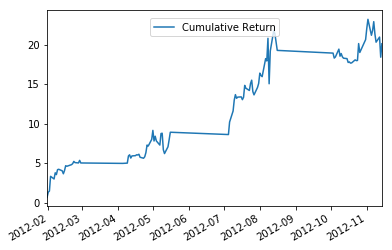

685505
679256
2018-05-02 16:30:16,855 [INFO] estimize.services.impl.estimize_signal_service_default_impl: get_signals: start
2018-05-02 16:30:17,595 [INFO] estimize.services.impl.estimize_signal_service_default_impl: get_signals: end


,Year,Cumulative Return,Avg Daily Return,Num Trading Days,Return (Annualized),Sharpe Ratio,Volatility
0,2013,0.113423,0.000741,152.0,0.186822,1.42091,0.131481


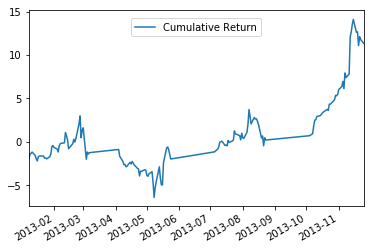

737635
734594
2018-05-02 16:30:41,652 [INFO] estimize.services.impl.estimize_signal_service_default_impl: get_signals: start
2018-05-02 16:30:42,346 [INFO] estimize.services.impl.estimize_signal_service_default_impl: get_signals: end


,Year,Cumulative Return,Avg Daily Return,Num Trading Days,Return (Annualized),Sharpe Ratio,Volatility
0,2014,0.133019,0.000854,151.0,0.215306,1.844415,0.116734


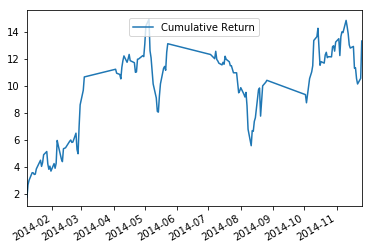

751815
745299
2018-05-02 16:31:10,199 [INFO] estimize.services.impl.estimize_signal_service_default_impl: get_signals: start
2018-05-02 16:31:10,919 [INFO] estimize.services.impl.estimize_signal_service_default_impl: get_signals: end


,Year,Cumulative Return,Avg Daily Return,Num Trading Days,Return (Annualized),Sharpe Ratio,Volatility
0,2015,0.228892,0.001328,160.0,0.334689,2.385828,0.140282


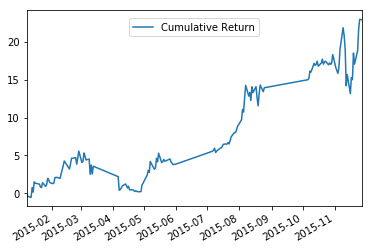

757698
745295
2018-05-02 16:31:42,362 [INFO] estimize.services.impl.estimize_signal_service_default_impl: get_signals: start
2018-05-02 16:31:43,414 [INFO] estimize.services.impl.estimize_signal_service_default_impl: get_signals: end


,Year,Cumulative Return,Avg Daily Return,Num Trading Days,Return (Annualized),Sharpe Ratio,Volatility
0,2016,-0.043248,-0.000228,158.0,-0.057556,-0.358435,0.160577


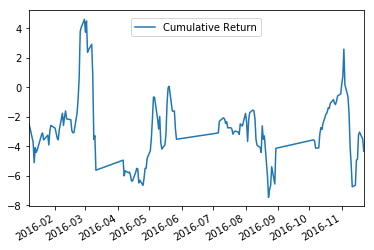

758093
742609
2018-05-02 16:32:10,056 [INFO] estimize.services.impl.estimize_signal_service_default_impl: get_signals: start
2018-05-02 16:32:10,643 [INFO] estimize.services.impl.estimize_signal_service_default_impl: get_signals: end


,Year,Cumulative Return,Avg Daily Return,Num Trading Days,Return (Annualized),Sharpe Ratio,Volatility
0,2017,0.189944,0.001255,147.0,0.316301,1.665928,0.189865


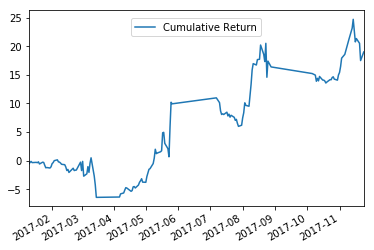

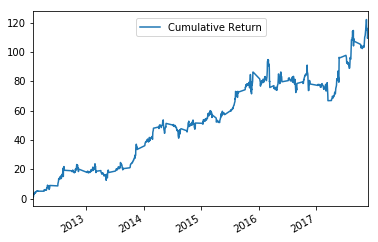

,Cumulative Return,Avg Daily Return,Num Trading Days,Return (Annualized),Sharpe Ratio,Volatility
0,0.137214,0.000945,146.333333,0.238019,1.623506,0.149066


In [7]:
df = show_yearly_performance(range(2012, 2018))
